In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import scipy.misc
from time import time
%matplotlib notebook

In [6]:
# Paths
image_path = 'source.tiff'
mask_path = 'mask.tiff'

# Load the image (grayscale) and the mask
img = np.asarray(Image.open(image_path).convert('L'))
mask = np.asarray(Image.open(mask_path))[:,:,0]

# plt.imshow(img, cmap="gray")
# plt.show()

# Normalize images to float in [0,1]; Change the name to fit the paper
I = img.astype(np.float32) / 255.
p = mask.astype(np.float32) / 255.

Elapsed time V1 :  0.043 s


<IPython.core.display.Javascript object>


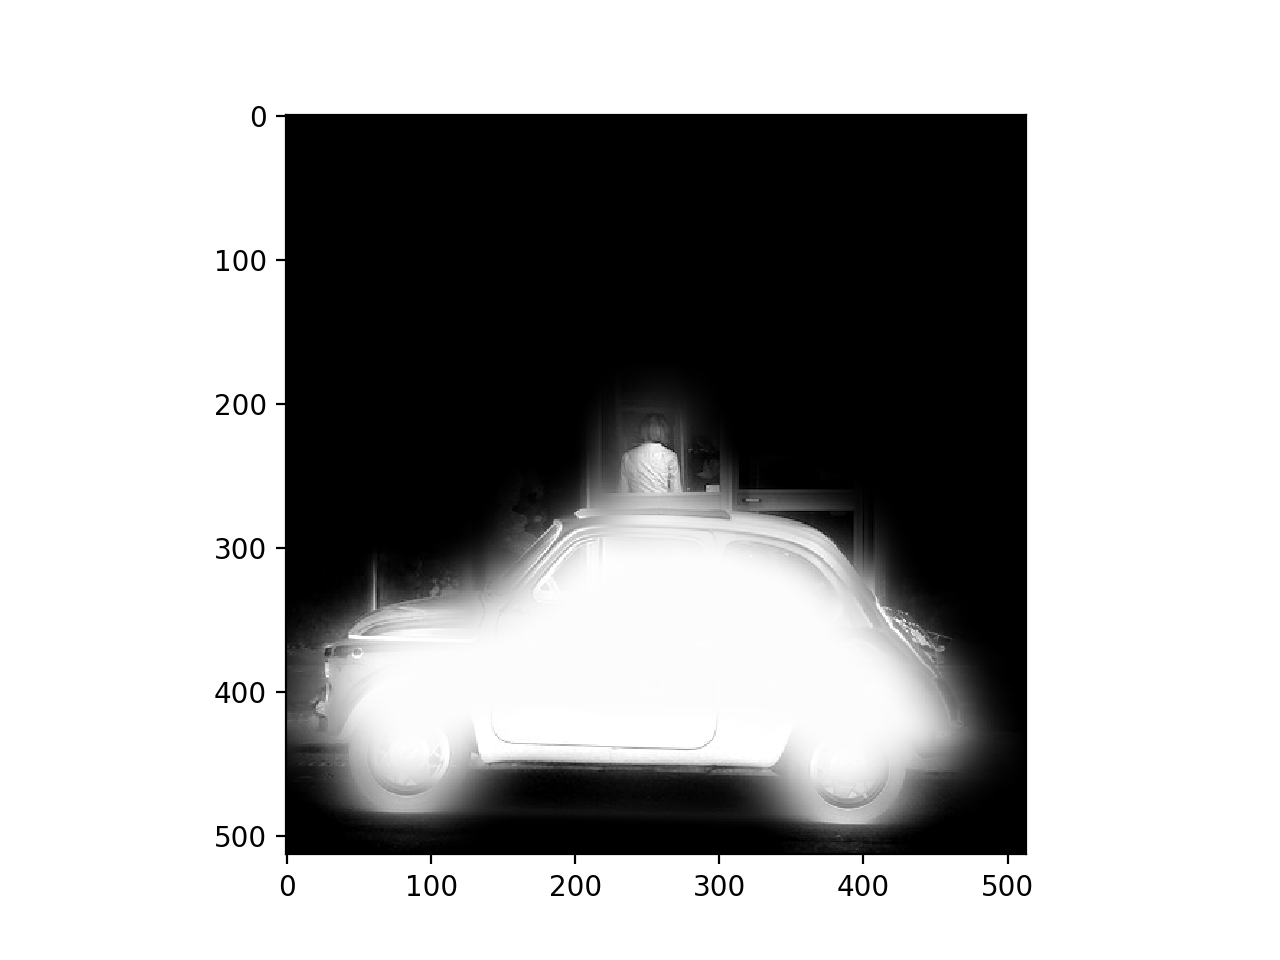

In [7]:
def box_filter(img, r):

    height, width = img.shape

    # Vertical pass
    iiv = np.cumsum(img, axis=0)
    img2 = np.zeros(img.shape, dtype=np.float)
    img2[0:r+1, :] = iiv[r:2*r+1, :] / np.array(range(r+1, 2*r+2)).reshape((r+1,1))
    img2[r+1:height-r, :] = (iiv[2*r+1:height, :] - iiv[0:height-2*r-1, :]) / (2*r+1)
    img2[height-r:height,:] = (iiv[height-1,:] - iiv[height-2*r-1:height-r-1,:]) / np.array(range(2*r, r, -1)).reshape((r,1))

    # Horizontal pass
    iih = np.cumsum(img2, axis=1)
    img3 = np.zeros(img.shape, dtype=np.float)
    img3[:, 0:r+1] = iih[:, r:2*r+1] / np.array(range(r+1, 2*r+2)).reshape((1, r+1))
    img3[:, r+1:width-r] = (iih[:, 2*r+1:width] - iih[:, 0:width-2*r-1]) / (2*r+1)
    img3[:, width-r:width] = (np.expand_dims(iih[:,width-1], axis=1) - iih[:,width-2*r-1:width-r-1]) / np.array(range(2*r, r, -1)).reshape((1,r))

    return img3


def guided_filter(I, p, radius, eps):

    # Compute I * p
    Ip = np.multiply(I, p)
    I2 = I**2

    # Compute some values
    I_mean = box_filter(I, radius)
    p_mean = box_filter(p, radius)
    Ip_mean = box_filter(Ip, radius)
    I2_mean = box_filter(I2, radius)
    I_var = I2_mean - I_mean**2

    # Compute a and b
    a = (Ip_mean - np.multiply(I_mean, p_mean)) / (I_var + eps)
    b = p_mean - np.multiply(a, I_mean)

    # Deduce a_mean and b_mean
    a_mean = box_filter(a, radius)
    b_mean = box_filter(b, radius)

    # Finally get the output mask
    q = np.multiply(a_mean, I) + b_mean

    # Clip values in [0,1]
    q = np.clip(q, 0, 1)

    return q

# Test the guided filter
radius = 21
eps = 0.0001

tic = time()
q = guided_filter(I, p, radius, eps)
toc = time()
print('Elapsed time V1 : %6.3f s' % (toc-tic))

plt.figure()
plt.imshow(q, cmap="gray")
plt.show()

Elapsed time Frida :  0.059 s


<IPython.core.display.Javascript object>


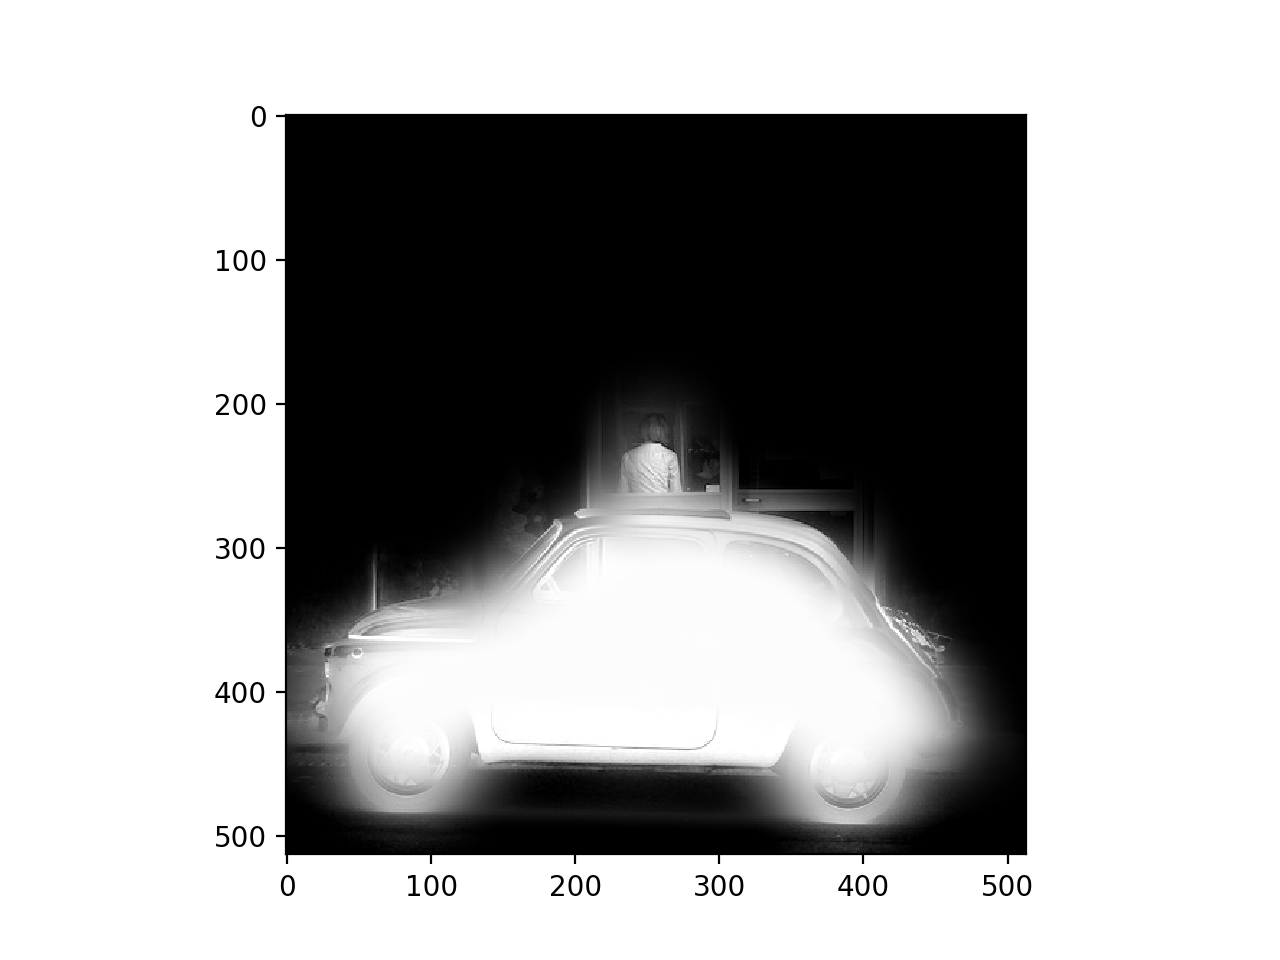

float32
float32
Elapsed time OpenCV :  0.009 s
Max diff = 0.090979 (range [0,1])


<IPython.core.display.Javascript object>


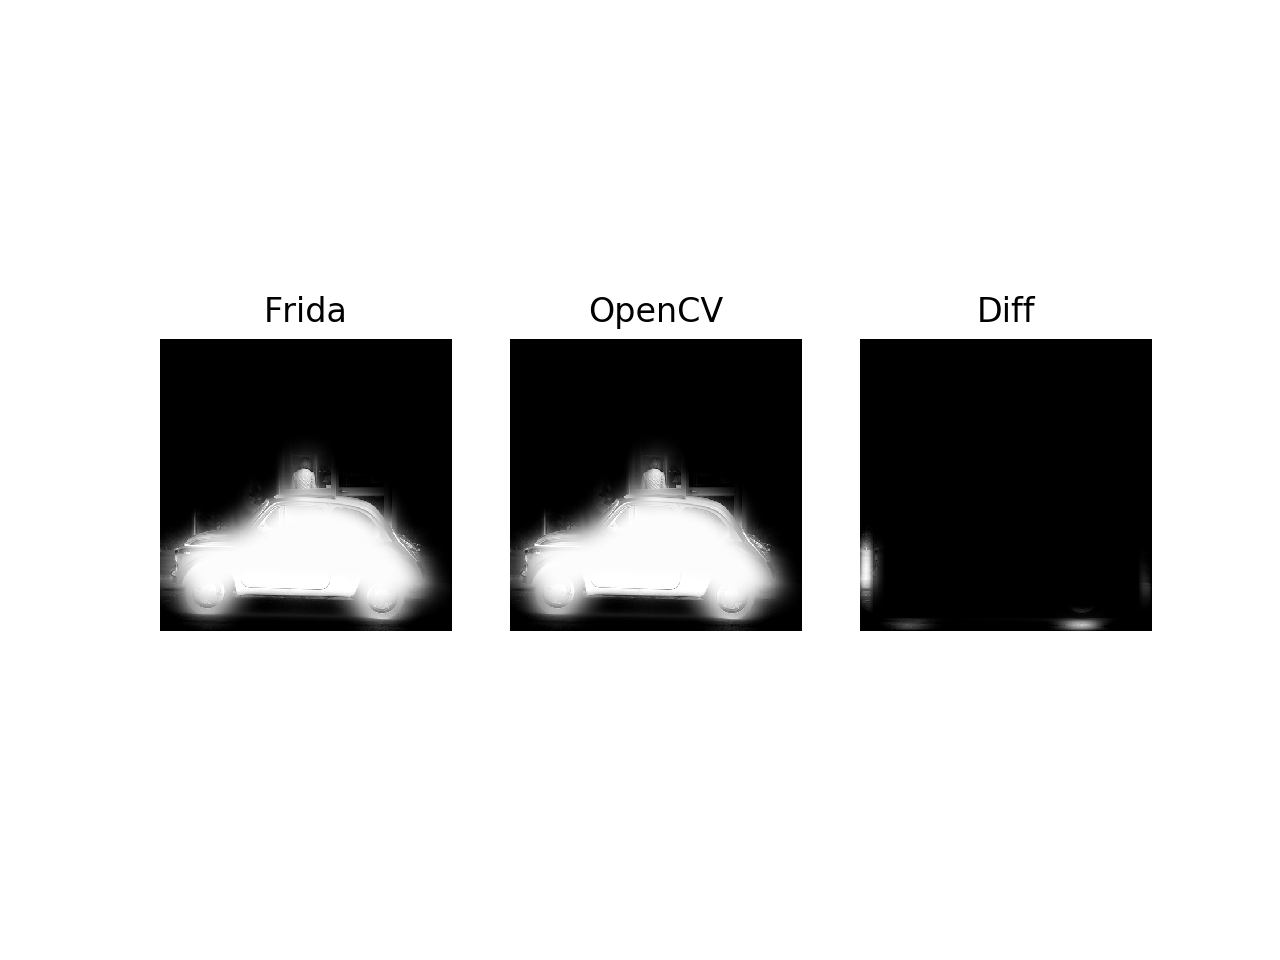

In [9]:
# Test the guided filter
radius = 23
eps = 0.0001

tic = time()
q = guided_filter(I, p, radius, eps)
toc = time()
print('Elapsed time Frida : %6.3f s' % (toc-tic))

plt.figure()
plt.imshow(q, cmap="gray")
plt.show()

import cv2

print(I.dtype)
print(p.dtype)

tic = time()
q2 = np.clip(cv2.ximgproc.guidedFilter(I, p, radius, eps), 0, 1.)
toc = time()
print('Elapsed time OpenCV : %6.3f s' % (toc-tic))

# plt.figure()
# plt.imshow(q2, cmap="gray")
# plt.show()

d = abs(q2 - q)
print('Max diff = %f (range [0,1])' % np.max(d))

f, ax = plt.subplots(1,3)
ax[0].imshow(q, cmap='gray')
ax[1].imshow(q2, cmap='gray')
ax[2].imshow(d, cmap='gray')
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
ax[0].set_title('Frida')
ax[1].set_title('OpenCV')
ax[2].set_title('Diff')
plt.show()

In [15]:
print(np.mean(q), np.max(q))
print(np.mean(q2), np.max(q2))

(0.2628205431864136, 1.0)
(0.26204762, 1.5183572)


In [42]:
d = abs(q2 - q)

In [43]:
print(np.min(d), np.max(d))

(0.0, 0.09097900682613946)


<IPython.core.display.Javascript object>


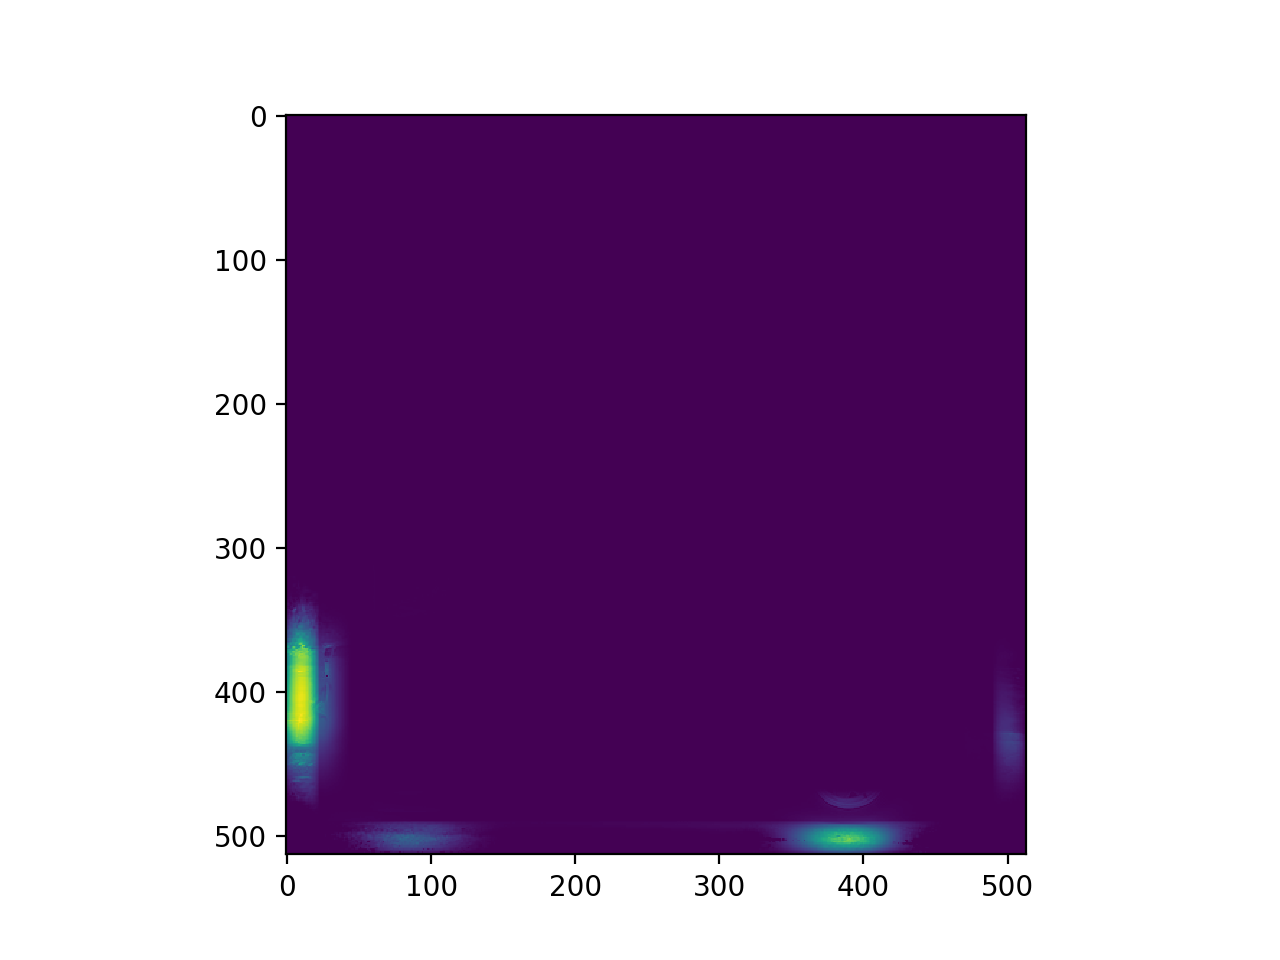

In [44]:
plt.figure()
plt.imshow(d)
plt.show()